In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from glob import glob
import pickle

from PIL import ImageColor
import matplotlib.colors

from utils import FEATURES_DIR, RESULTS_DIR, SUBJECTS
from analyses.ridge_regression_decoding import NUM_CV_SPLITS, DECODER_OUT_DIR, calc_rsa, calc_rsa_images, calc_rsa_captions, get_fmri_data
from analyses.calc_noise_ceilings import RSA_NOISE_CEILING_DIR, load_mean_std
from notebook_utils import load_results_data, add_avg_subject

In [2]:
def calc_alt_rsas():
    results_root_dir = os.path.expanduser(f'~/data/multimodal_decoding/glm/')

    result_files = sorted(glob(f"{results_root_dir}/*/*/*/results.p"))
    for result_file_path in tqdm(result_files):        
        results = pickle.load(open(result_file_path, 'rb'))

        for metric in ["spearmanr", "pearsonr"]:
            for matrix_metric in ["spearmanr", "pearsonr"]:
                rsa = calc_rsa(results['predictions'], results['latents'], metric, matrix_metric)
                results[f"rsa_{metric}_{matrix_metric}"] = rsa

        pickle.dump(results, open(result_file_path, 'wb'))

# def calc_alt_rsas_imgs_captions():
#     results_root_dir = os.path.expanduser(f'~/data/multimodal_decoding/glm/')

#     result_files = sorted(glob(f"{results_root_dir}/*/*/*/results.p"))
#     for result_file_path in tqdm(result_files):        
#         results = pickle.load(open(result_file_path, 'rb'))
#         results['rsa_images'] = calc_rsa_images(results['predictions'], results['latents'], results['stimulus_types'])
#         results['rsa_captions'] = calc_rsa_captions(results['predictions'], results['latents'], results['stimulus_types'])

#         pickle.dump(results, open(result_file_path, 'wb'))

# calc_alt_rsas()
# calc_alt_rsas_imgs_captions()

In [3]:
def calc_new_rsa():
    fmri_test_betas = dict()
    for subj in SUBJECTS:
        fmri_test_betas[subj], _, _, _ = get_fmri_data(subj, "test", load_mean_std(subj))

    results_root_dir = os.path.expanduser(f'~/data/multimodal_decoding/glm/')

    result_files = sorted(glob(f"{results_root_dir}/*/*/*/results.p"))
    for result_file_path in tqdm(result_files):        
        results = pickle.load(open(result_file_path, 'rb'))
        betas = fmri_test_betas[results['subject']]
        results['rsa_images'] = calc_rsa_images(betas, results['latents'], results['stimulus_types'])
        results['rsa_captions'] = calc_rsa_captions(betas, results['latents'], results['stimulus_types'])

        pickle.dump(results, open(result_file_path, 'wb'))

# calc_new_rsa()

In [4]:
all_data = load_results_data()

MODELS_EXCLUDED = [] #"bridgetower-large"
all_data = all_data[~all_data.model.isin(MODELS_EXCLUDED)].copy()

all_data

,alpha,model,subject,features,training_mode,testing_mode,mask,num_voxels,best_val_acc,metric,value,best_val_loss,ensemble,model_feat
0,100000.0,bert-base-uncased,sub-01,lang,modality-agnostic,test,whole_brain,162649.0,True,pairwise_acc,0.861387,NaN,NaN,bert-base-uncased_lang
1,100000.0,bert-base-uncased,sub-01,lang,modality-agnostic,test,whole_brain,162649.0,True,pairwise_acc_captions,0.860455,NaN,NaN,bert-base-uncased_lang
2,100000.0,bert-base-uncased,sub-01,lang,modality-agnostic,test,whole_brain,162649.0,True,pairwise_acc_images,0.884472,NaN,NaN,bert-base-uncased_lang
3,10000.0,bert-base-uncased,sub-01,lang,modality-agnostic,test,anatomical_lang,11110.0,True,pairwise_acc,0.801139,NaN,NaN,bert-base-uncased_lang
4,10000.0,bert-base-uncased,sub-01,lang,modality-agnostic,test,anatomical_lang,11110.0,True,pairwise_acc_captions,0.815321,NaN,NaN,bert-base-uncased_lang
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19361,100000.0,vit-l-16,sub-07,vision,images,test,anatomical_occipital_exclusive,8559.0,True,pairwise_acc_captions,0.604969,NaN,NaN,vit-l-16_vision
19362,100000.0,vit-l-16,sub-07,vision,images,test,anatomical_occipital_exclusive,8559.0,True,pairwise_acc_images,0.900621,NaN,NaN,vit-l-16_vision
19363,100000.0,vit-l-16,sub-07,vision,images,test,anatomical_visual_high_level,10015.0,True,pairwise_acc,0.750104,NaN,NaN,vit-l-16_vision
19364,100000.0,vit-l-16,sub-07,vision,images,test,anatomical_visual_high_level,10015.0,True,pairwise_acc_captions,0.708075,NaN,NaN,vit-l-16_vision


In [5]:
all_data_avg = add_avg_subject(all_data)
all_data_avg = all_data_avg[all_data_avg.subject == "average"]

In [6]:
MODEL_ORDER = ["random-flava", "vit-b-16", "vit-l-16", "resnet-18", "resnet-50", "resnet-152", "dino-base", "dino-large", "dino-giant",
               "bert-base-uncased", "bert-large-uncased", "llama2-7b", "llama2-13b", "mistral-7b", "mixtral-8x7b", "gpt2-small", "gpt2-medium", "gpt2-large", "gpt2-xl",
               "visualbert", "bridgetower-large", "clip", "flava", "imagebind", "lxmert", "vilt"]


# ref performance order:
#['random-flava', 'resnet-152', 'vit-b-16', 'vit-l-16', 'resnet-18', 'resnet-50', 'dino-giant', 'dino-large', 'dino-base', 'bert-large-uncased', 'bert-base-uncased',
# 'llama2-7b', 'mixtral-8x7b', 'mistral-7b', 'llama2-13b', 'gpt2-small', 'gpt2-medium', 'gpt2-xl', 'gpt2-large', 'visualbert', 'bridgetower-large', 'clip', 'flava', 'imagebind', 'lxmert', 'vilt']

def calc_model_feat_order(data):
    all_model_feats = data.model_feat.unique()
    all_models = data.model.unique()
    for model in all_models:
        if model not in MODEL_ORDER:
            raise RuntimeError(f"Model missing in order: {model}")
    model_feat_order = []
    for model in MODEL_ORDER:
        for feats in ["vision", "lang", "vision+lang"]:
            model_feat = f"{model}_{feats}"
            if model_feat in all_model_feats:
                model_feat_order.append(model_feat)

    return model_feat_order

In [7]:
distance_metric = 'cosine'
METRICS = [f'acc_{distance_metric}', f'acc_{distance_metric}_captions', f'acc_{distance_metric}_images']


In [8]:
def plot_metric(data, kind="bar", x_variable="model_feat", order=None, hue_variable="model_feat", hue_order=None, metric="pairwise_acc", ylim=(0.5, 1), plot_legend=True, palette=None,
                noise_ceiling=None, hatches=None, axis=None, marker="o", markersize=5, legend_title="Model features modality", dodge=False):
    data_filtered = data[data.metric == metric]

    sns.set_style("ticks", {'axes.grid' : True})
    if kind == "bar":
        g = sns.barplot(data_filtered, x=x_variable, order=order, y="value", hue=hue_variable, hue_order=hue_order, palette=palette, err_kws={'linewidth': 0.5}, width=0.95)
    elif kind == "point":
        g = sns.pointplot(data_filtered, x=x_variable, order=order, y="value", hue=hue_variable, hue_order=hue_order, palette=palette,
                          errorbar=None, marker=marker, markersize=markersize, markeredgewidth=1, linestyle="none", ax=axis, dodge=dodge)

    g.legend().remove()
    bbox_extra_artists = None
    if plot_legend:
        # lgd = g.legend(loc='upper left', title="", bbox_to_anchor=(0.05, 0.95), ncol=9)
        lgd = g.legend(ncol=3, title=legend_title)
        bbox_extra_artists = (lgd,)

    if noise_ceiling is not None:
        g.axhline(y=noise_ceiling)

    if hatches is not None:
        for i, thisbar in enumerate(g.patches[:len(hatches)]):
            thisbar.set_hatch(hatches[i])

    g.set(ylim=ylim, ylabel=metric, xlabel='')

    # print(g.get_xticklabels())
    # g.set_xticklabels([label.get_text().split('_')[0] for label in g.get_xticklabels()], rotation=80)

    plt.tight_layout()
    
    return g, data_filtered

In [9]:
def get_short_label_text(label, cut_labels=True):
    text = label.get_text().split('_')[0]
    if cut_labels and (len(text) > 10):
        text = f"{'-'.join(text.split('-')[:-1])}-\n{text.split('-')[-1]}"
    return text
    
def plot_metric_catplot(data, kind="bar", x_variable="model_feat", order=None, row_variable="subject", row_order=None, col_variable=None, hue_variable="model_feat", hue_order=None, metrics=["pairwise_acc"], ylim=(0.5, 1),
                        plot_legend=True, palette=None, noise_ceilings=None, hatches=None, legend_title="Model features modality", height=4, aspect=4, legend_bbox=(0.05,1), rotation=80, cut_labels=True):
    data_filtered = data[data.metric.isin(metrics)]

    sns.set_style("ticks", {'axes.grid' : True})
    g = sns.catplot(data_filtered, kind=kind, x=x_variable, order=order, y="value", row=row_variable, row_order=row_order, col=col_variable, height=height, aspect=aspect, hue=hue_variable, hue_order=hue_order,
                    palette=palette, err_kws={'linewidth': 0.5, 'alpha': 0.99}, width=0.7)
   
    g._legend.remove()
    bbox_extra_artists = None
    if plot_legend:
        # lgd = g.fig.legend(loc='upper left', title="", bbox_to_anchor=(1, 0.9), ncol=2)
        lgd = g.fig.legend(ncol=2, title=legend_title, loc="upper left", bbox_to_anchor=legend_bbox)#, bbox_to_anchor=(0.02, 0.95), ncol=9)
        bbox_extra_artists = (lgd,)

    for i in range(len(g.axes[-1])):
        last_axis = g.axes[-1][i]
        last_axis.set_xticklabels([get_short_label_text(label, cut_labels) for label in last_axis.get_xticklabels()], rotation=rotation)
        
    g.set(ylim=ylim, ylabel="pairwise_acc", xlabel='')
    
    plt.tight_layout()
    
    return g, data_filtered, lgd

## Modality-agnostic decoding vs. modality-specific decoding

In [10]:
FEAT_ORDER = ["vision", "lang", "vision+lang"]
FEAT_PALETTE = sns.color_palette('Set2')[:3]

def create_result_graph(data, model_feat_order, metrics=["pairwise_acc_captions", "pairwise_acc_images"], hue_variable="features", hue_order=FEAT_ORDER, ylim=None,
                        legend_title="Legend", palette=FEAT_PALETTE, dodge=False, noise_ceilings=None, plot_modality_specific=True,
                       row_variable="metric", row_order=None, col_variable=None, legend_bbox=(0.06,1), height=4.5, aspect=4):
    data_training_mode_full = data[data.training_mode == "modality-agnostic"]
    data_training_mode_captions = data[data.training_mode == "captions"]
    data_training_mode_images = data[data.training_mode == "images"]

    # print(len(data_training_mode_full[(data_training_mode_full.model_feat == 'lxmert_vision+lang')& (data_training_mode_full.metric == metrics[0]) ]))
    length = len(data_training_mode_full[(data_training_mode_full.model_feat == 'lxmert_vision+lang') & (data_training_mode_full.metric == metrics[0])])
    # assert length == 6, f"too long or short: {length}"

    catplot_g, data_plotted, lgd = plot_metric_catplot(data_training_mode_full, order=model_feat_order, metrics=metrics, x_variable="model_feat", legend_title=legend_title, legend_bbox=legend_bbox, height=height, aspect=aspect,
                                                  hue_variable=hue_variable, row_variable=row_variable, row_order=row_order, col_variable=col_variable, hue_order=hue_order, palette=palette, ylim=ylim, noise_ceilings=noise_ceilings)

    if plot_modality_specific:
        _ = plot_metric(data_training_mode_captions, kind="point", order=model_feat_order, metric=metrics[0], x_variable="model_feat", dodge=dodge,
                                      hue_variable=hue_variable, hue_order=hue_order, palette=[(0, 0, 0)], axis=catplot_g.axes[0, 0], marker="o", plot_legend=False, ylim=ylim)
        g, _ = plot_metric(data_training_mode_images, kind="point", order=model_feat_order, metric=metrics[0], x_variable="model_feat", dodge=dodge,
                                      hue_variable=hue_variable, hue_order=hue_order, palette=[(0, 0, 0)], axis=catplot_g.axes[0, 0], marker="x", plot_legend=False, ylim=ylim)
        
        _ = plot_metric(data_training_mode_captions, kind="point", order=model_feat_order, metric=metrics[1], x_variable="model_feat", dodge=dodge,
                                      hue_variable=hue_variable, hue_order=hue_order, palette=[(0, 0, 0)], axis=catplot_g.axes[1, 0], marker="o", plot_legend=False, ylim=ylim)
        _ = plot_metric(data_training_mode_images, kind="point", order=model_feat_order, metric=metrics[1], x_variable="model_feat", dodge=dodge,
                                      hue_variable=hue_variable, hue_order=hue_order, palette=[(0, 0, 0)], axis=catplot_g.axes[1, 0], marker="x", plot_legend=False, ylim=ylim)

        if len(metrics) == 3:
            _ = plot_metric(data_training_mode_captions, kind="point", order=model_feat_order, metric=metrics[2], x_variable="model_feat", dodge=dodge,
                                          hue_variable=hue_variable, hue_order=hue_order, palette=[(0, 0, 0)], axis=catplot_g.axes[2, 0], marker="o", plot_legend=False, ylim=ylim)
            _ = plot_metric(data_training_mode_images, kind="point", order=model_feat_order, metric=metrics[2], x_variable="model_feat", dodge=dodge,
                                          hue_variable=hue_variable, hue_order=hue_order, palette=[(0, 0, 0)], axis=catplot_g.axes[2, 0], marker="x", plot_legend=False, ylim=ylim)
            
        handles, labels = g.get_legend_handles_labels()
        new_labels = ["captions", "images"]
        new_handles = [handles[0], handles[-1]]
        catplot_g.fig.legend(handles=new_handles, labels=new_labels, ncol=2, title="Modality-specific decoders trained on", loc='upper right') #, bbox_to_anchor=(0.05,1)
        
        catplot_g.axes[0, 0].set_title(catplot_g.axes[0,0].title.get_text().split("_")[-1], fontsize=30, y=0.97)
        catplot_g.axes[1, 0].set_title(catplot_g.axes[1,0].title.get_text().split("_")[-1], fontsize=30, y=0.97)
     
        catplot_g.axes[0, 0].set_ylabel('pairwise accuracy')
        catplot_g.axes[1, 0].set_ylabel('pairwise accuracy')

        if len(metrics) == 3:
            catplot_g.axes[2, 0].set_title("overall", fontsize=30, y=0.97)
            catplot_g.axes[2, 0].set_ylabel('pairwise accuracy')

    plt.subplots_adjust(hspace=0.15)
    return catplot_g, lgd


In [11]:
multimodal_models = all_data_avg[all_data_avg.features == "vision+lang"].model.unique()
MODEL_FEAT_MULTIMODAL_SINGLE_MODALITY = [m+'_lang' for m in multimodal_models] + [m+'_vision' for m in multimodal_models]

### Model performance ranking

In [12]:
dp = all_data_avg

MODEL_FEATS_EXCLUDED = ["bridgetower-large_multi", "random-flava_vision", "random-flava_lang"] + MODEL_FEAT_MULTIMODAL_SINGLE_MODALITY
dp = dp[~dp.model_feat.isin(MODEL_FEATS_EXCLUDED)].copy()
dp = dp[dp["mask"] == "whole_brain"]

model_order = ['random-flava']
for features in ["vision", "lang", "vision+lang"]:
    model_scores = []
    data_feats = dp[(dp.features == features) & (dp.model != 'random-flava')]
    models = data_feats.model.unique()
    for model in models:
        # print(model)
        dp_model = dp[(dp.model == model) & (dp.training_mode == 'modality-agnostic')]
        dp_model_caps = dp_model[dp_model.metric == "pairwise_acc_captions"]
        assert len(dp_model_caps) == 6, len(dp_model_caps)
        # print(f"pairwise_acc_captions: {dp_model_caps.value.mean():.2f}")
        dp_model_imgs = dp_model[dp_model.metric == "pairwise_acc_images"]
        assert len(dp_model_imgs) == 6, len(dp_model_imgs)
        # print(f"pairwise_acc_images: {dp_model_imgs.value.mean():.2f}")
        avg = np.mean([dp_model_caps.value.mean(), dp_model_imgs.value.mean()])
        print(f"{model} pairwise_acc avg : {avg:.3f} std: {np.std(np.concatenate([dp_model_caps.value.to_numpy(), dp_model_imgs.value.to_numpy()])):.2f}")
        model_scores.append(avg)
        
        
    model_order.extend([model for _, model in sorted(zip(model_scores, models), key=lambda pair: pair[0])])
        # dp_model_mod_agn = dp_model[dp_model.metric == "pairwise_acc"]
        # print(f"pairwise_acc (modality-agnostic): {dp_model_mod_agn.value.mean():.3f} std: {dp_model_mod_agn.value.std():.2f}")
        # print("")
print(model_order)

['dino-base']
dino-base pairwise_acc avg : 0.834 std: 0.10
['dino-giant']
dino-giant pairwise_acc avg : 0.831 std: 0.10
['dino-large']
dino-large pairwise_acc avg : 0.834 std: 0.10
['resnet-152']
resnet-152 pairwise_acc avg : 0.773 std: 0.08
['resnet-18']
resnet-18 pairwise_acc avg : 0.807 std: 0.10
['resnet-50']
resnet-50 pairwise_acc avg : 0.815 std: 0.09
['vit-b-16']
vit-b-16 pairwise_acc avg : 0.784 std: 0.08
['vit-l-16']
vit-l-16 pairwise_acc avg : 0.804 std: 0.11
['bert-base-uncased']
bert-base-uncased pairwise_acc avg : 0.834 std: 0.05
['bert-large-uncased']
bert-large-uncased pairwise_acc avg : 0.815 std: 0.06
['gpt2-large']
gpt2-large pairwise_acc avg : 0.863 std: 0.05
['gpt2-medium']
gpt2-medium pairwise_acc avg : 0.858 std: 0.05
['gpt2-small']
gpt2-small pairwise_acc avg : 0.852 std: 0.05
['gpt2-xl']
gpt2-xl pairwise_acc avg : 0.859 std: 0.05
['llama2-13b']
llama2-13b pairwise_acc avg : 0.847 std: 0.06
['llama2-7b']
llama2-7b pairwise_acc avg : 0.835 std: 0.05
['mistral-7b']

<ipython-input-9-f46e84c1ecf3>:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels([get_short_label_text(label, cut_labels) for label in last_axis.get_xticklabels()], rotation=rotation)
<ipython-input-8-253b4d8a486d>:9: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  g = sns.pointplot(data_filtered, x=x_variable, order=order, y="value", hue=hue_variable, hue_order=hue_order, palette=palette,
<ipython-input-8-253b4d8a486d>:9: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  g = sns.pointplot(data_filtered, x=x_variable, order=order, y="value", hue=hue_variable, hue_order=hue_order, palette=palette,
<ipython-input-8-253b4d8a486d>:9: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which ma

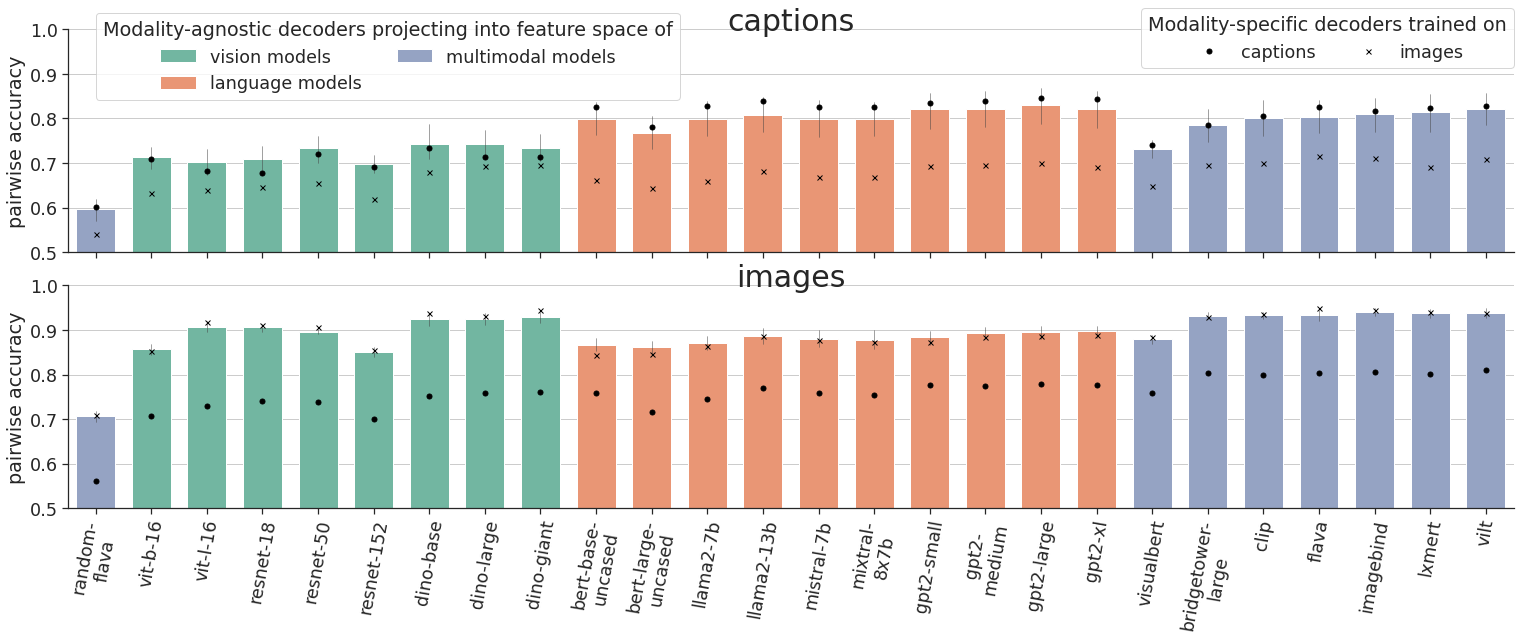

In [13]:
sns.set(font_scale=1.6)
TRAIN_MODE_ORDER = ["images", "captions", "modality-agnostic"]
# FEAT_ORDER = ["vision", "lang", "vision+lang"]
FEAT_ORDER = ["vision models", "language models", "multimodal models"]

MODEL_FEATS_EXCLUDED = ["bridgetower-large_multi", "random-flava_vision", "random-flava_lang"] + MODEL_FEAT_MULTIMODAL_SINGLE_MODALITY
data_to_plot = all_data_avg[~all_data_avg.model_feat.isin(MODEL_FEATS_EXCLUDED)].copy()

data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models", "vision+lang": "multimodal models"})

data_to_plot = data_to_plot[data_to_plot["mask"] == "whole_brain"]
model_feat_order = calc_model_feat_order(data_to_plot)

figure, lgd = create_result_graph(data_to_plot, model_feat_order, metrics=["pairwise_acc_captions", "pairwise_acc_images"], hue_order=FEAT_ORDER, ylim=(0.5, 1),
                             legend_bbox=(0.06, 0.99), height=4.5, legend_title="Modality-agnostic decoders projecting into feature space of")
plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_pairwise_acc.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300, pad_inches=0)

<ipython-input-9-f46e84c1ecf3>:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels([get_short_label_text(label, cut_labels) for label in last_axis.get_xticklabels()], rotation=rotation)
<ipython-input-8-253b4d8a486d>:9: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  g = sns.pointplot(data_filtered, x=x_variable, order=order, y="value", hue=hue_variable, hue_order=hue_order, palette=palette,
<ipython-input-8-253b4d8a486d>:9: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  g = sns.pointplot(data_filtered, x=x_variable, order=order, y="value", hue=hue_variable, hue_order=hue_order, palette=palette,
<ipython-input-8-253b4d8a486d>:9: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which ma

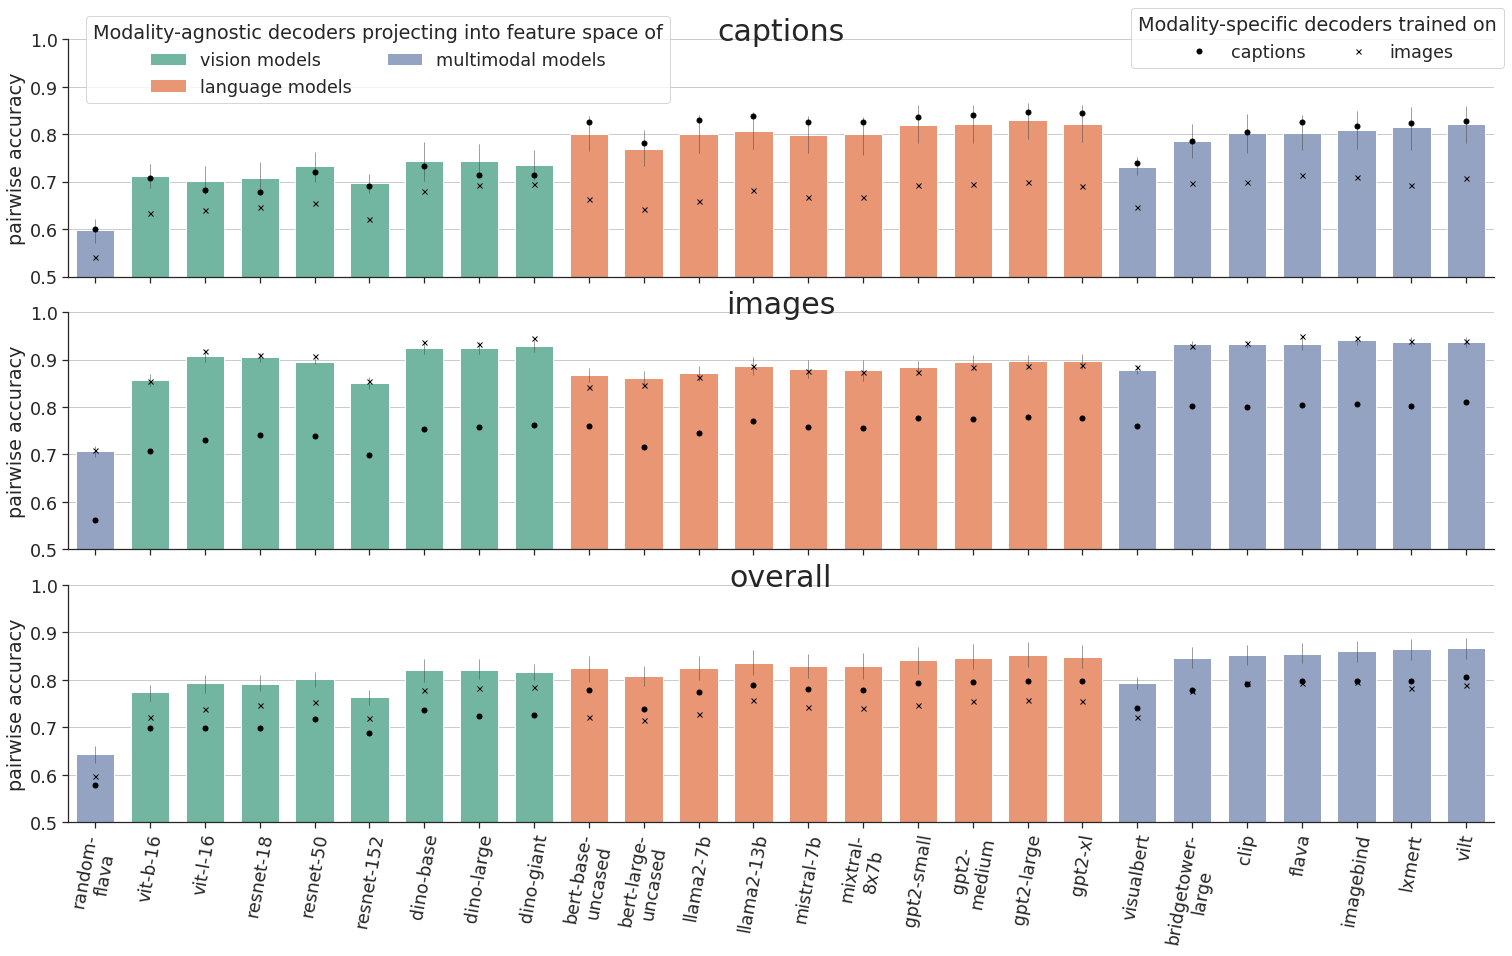

In [14]:
sns.set(font_scale=1.6)
TRAIN_MODE_ORDER = ["images", "captions", "modality-agnostic"]
# FEAT_ORDER = ["vision", "lang", "vision+lang"]

MODEL_FEATS_EXCLUDED = ["bridgetower-large_multi", "random-flava_vision", "random-flava_lang"] + MODEL_FEAT_MULTIMODAL_SINGLE_MODALITY
data_to_plot = all_data_avg[~all_data_avg.model_feat.isin(MODEL_FEATS_EXCLUDED)].copy()

data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models", "vision+lang": "multimodal models"})

data_to_plot = data_to_plot[data_to_plot["mask"] == "whole_brain"]
model_feat_order = calc_model_feat_order(data_to_plot)

metrics_order = ["pairwise_acc_captions", "pairwise_acc_images", "pairwise_acc"]
figure, lgd = create_result_graph(data_to_plot, model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=FEAT_ORDER, ylim=(0.5, 1),
                             legend_bbox=(0.06,0.99), height=4.5, legend_title="Modality-agnostic decoders projecting into feature space of")
plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_pairwise_acc_with_modality_agnostic.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)


## V, L, or multimodal feats for multimodal models

<ipython-input-9-f46e84c1ecf3>:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels([get_short_label_text(label, cut_labels) for label in last_axis.get_xticklabels()], rotation=rotation)
<ipython-input-8-253b4d8a486d>:9: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  g = sns.pointplot(data_filtered, x=x_variable, order=order, y="value", hue=hue_variable, hue_order=hue_order, palette=palette,
<ipython-input-8-253b4d8a486d>:9: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  g = sns.pointplot(data_filtered, x=x_variable, order=order, y="value", hue=hue_variable, hue_order=hue_order, palette=palette,
<ipython-input-8-253b4d8a486d>:9: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which ma

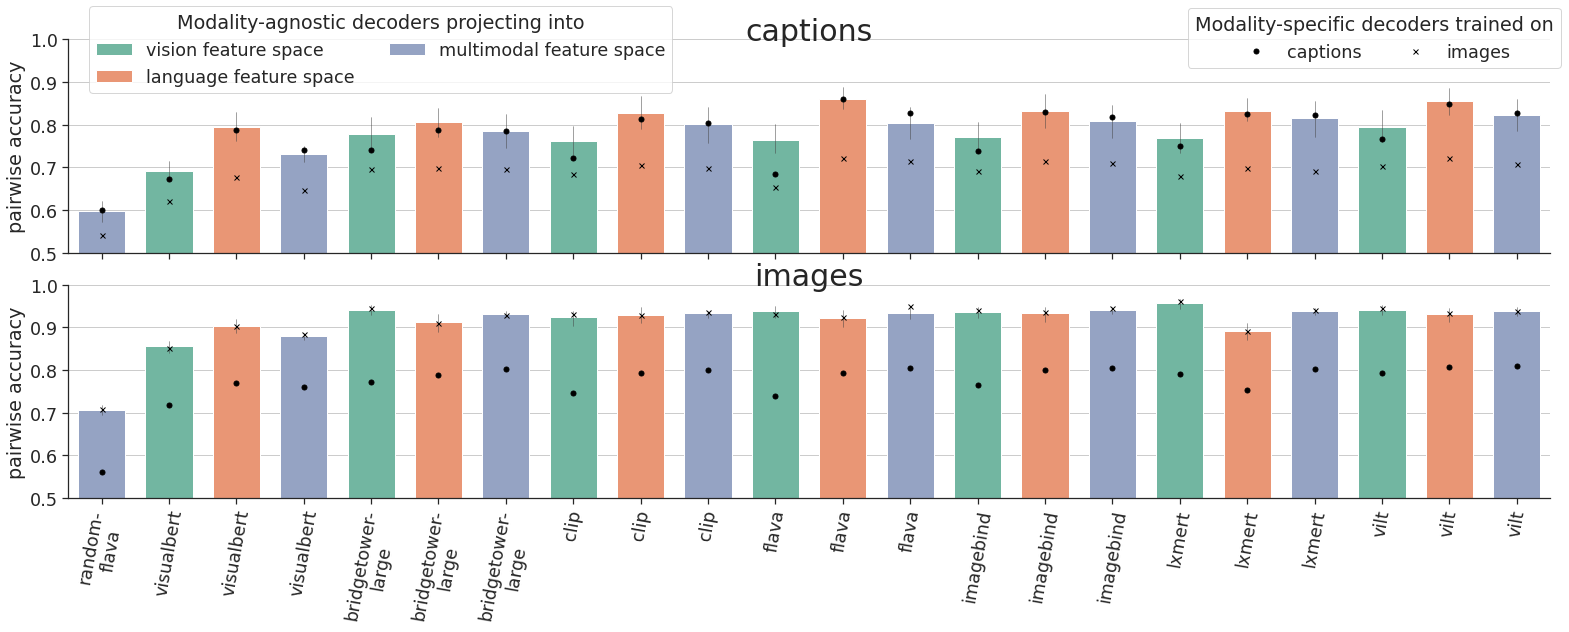

In [15]:
feat_order = ["vision feature space", "language feature space", "multimodal feature space"]

model_feats_exluded = ["bridgetower-large_multi", "random-flava_vision", "random-flava_lang"]
data_to_plot = all_data_avg[~all_data_avg.model_feat.isin(model_feats_exluded)].copy()

data_to_plot = data_to_plot[data_to_plot.model.isin(multimodal_models)]

data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision feature space", "lang": "language feature space", "vision+lang": "multimodal feature space"})

data_to_plot = data_to_plot[data_to_plot["mask"] == "whole_brain"]
model_feat_order = calc_model_feat_order(data_to_plot)

figure, lgd = create_result_graph(data_to_plot, model_feat_order, metrics=["pairwise_acc_captions", "pairwise_acc_images"], hue_order=feat_order, ylim=(0.5, 1),
                             legend_bbox=(0.06,1), height=4.5, legend_title="Modality-agnostic decoders projecting into")
plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_pairwise_acc_multimodal_models.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)

In [16]:
# RSA_METRIC = "spearmanr"
# RSA_MATRIX_METRIC = "spearmanr"
# rsa_noise_ceilings_path = os.path.join(RSA_NOISE_CEILING_DIR, f"{RSA_METRIC}_{RSA_MATRIX_METRIC}.p")
# rsa_noise_ceilings = pickle.load(open(rsa_noise_ceilings_path, 'rb'))
# rsa_noise_ceiling_captions_mean = np.mean(list(rsa_noise_ceilings["rsa_captions"].values()))
# rsa_noise_ceiling_images_mean = np.mean(list(rsa_noise_ceilings["rsa_images"].values()))

# create_result_graph(data_no_mask, model_feat_order, metrics=["rsa_captions", "rsa_images"], ylim=(0, 0.2)) #, noise_ceilings=[rsa_noise_ceiling_captions_mean, rsa_noise_ceiling_images_mean])
# plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_rsa.png"), dpi=300)

## ROI-based decoding

<ipython-input-9-f46e84c1ecf3>:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels([get_short_label_text(label, cut_labels) for label in last_axis.get_xticklabels()], rotation=rotation)
<ipython-input-8-253b4d8a486d>:9: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  g = sns.pointplot(data_filtered, x=x_variable, order=order, y="value", hue=hue_variable, hue_order=hue_order, palette=palette,
<ipython-input-8-253b4d8a486d>:9: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  g = sns.pointplot(data_filtered, x=x_variable, order=order, y="value", hue=hue_variable, hue_order=hue_order, palette=palette,
<ipython-input-8-253b4d8a486d>:9: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which ma

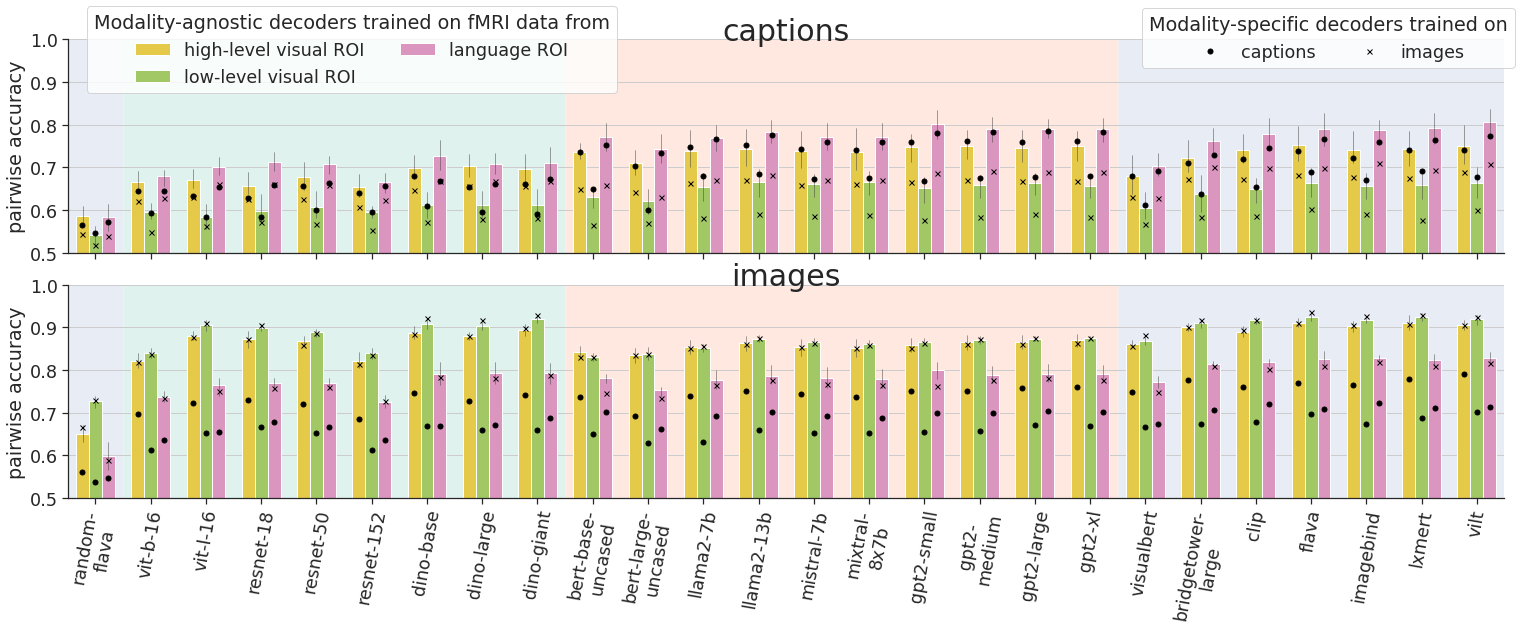

In [17]:
# MASK_ORDER = ["no_mask", "anatomical_visual", "anatomical_visual_occipital", "anatomical_temporal", "anatomical_temporal_exclusive", "anatomical_temporal_not_visual", "anatomical_visual_v1", "anatomical_lang_test", "anatomical_not_visual"]

# MASK_ORDER = ["no_mask", "anatomical_visual_occipital", "anatomical_temporal", "anatomical_temporal_exclusive", "anatomical_visual_v1", "anatomical_lang_test", "anatomical_angular_gyrus", "anatomical_left_angular_gyrus", "anatomical_middle_temporal_gyrus"]
# MASK_ORDER = ["whole_brain", "anatomical_visual_occipital", "anatomical_temporal_exclusive", "anatomical_visual_v1", "anatomical_lang", "anatomical_lang_test", "anatomical_lang_test_2", "anatomical_lang_test_3", "anatomical_lang_test_4", "anatomical_lang_test_5", "anatomical_angular_gyrus", "anatomical_left_angular_gyrus"]
MASK_ORDER = ["high-level visual ROI", "low-level visual ROI", "language ROI"]

MASK_PALETTE = sns.color_palette('Set2')[3:3+len(MASK_ORDER)][::-1]
# MASK_PALETTE = sns.color_palette('husl', len(MASK_ORDER))
# MASK_PALETTE = sns.color_palette("Set2")[3:]

# outdated mask:
all_data_avg = all_data_avg[all_data_avg["mask"] != "occipital"]

# MODEL_FEATS_INCLUDED = ["resnet-50_vision", "dino-giant_vision", "gpt2-large_lang", "llama2-13b_lang", "flava_vision+lang"]
# data_all_masks = all_data_avg[all_data_avg.model_feat.isin(MODEL_FEATS_INCLUDED)].copy()

MODEL_FEATS_EXCLUDED = ["bridgetower-large_multi", "random-flava_vision", "random-flava_lang"] + MODEL_FEAT_MULTIMODAL_SINGLE_MODALITY
data_all_masks = all_data_avg[~all_data_avg.model_feat.isin(MODEL_FEATS_EXCLUDED)].copy()

data_all_masks["mask"] = data_all_masks["mask"].replace({"anatomical_occipital_exclusive": "low-level visual ROI", "anatomical_lang": "language ROI", "anatomical_visual_high_level": "high-level visual ROI"})

data_all_masks = data_all_masks[data_all_masks["mask"].isin(MASK_ORDER)].copy()

# data_mask = data_training_modes[data_training_modes["mask"] == ROI_MASK]

model_feat_order = calc_model_feat_order(data_all_masks)

figure, lgd = create_result_graph(data_all_masks, model_feat_order, metrics=["pairwise_acc_captions", "pairwise_acc_images"], hue_variable="mask", hue_order=MASK_ORDER, palette=MASK_PALETTE, ylim=(0.5, 1),
                             legend_title="Modality-agnostic decoders trained on fMRI data from", dodge=0.47)

colors_bg = sns.color_palette('Set2')[:3]
figure.axes[0, 0].axvspan(-0.5, 0.5, facecolor=colors_bg[2], alpha=0.2, zorder=-100)
figure.axes[1, 0].axvspan(-0.5, 0.5, facecolor=colors_bg[2], alpha=0.2, zorder=-100)
figure.axes[0, 0].axvspan(0.5, 8.5, facecolor=colors_bg[0], alpha=0.2, zorder=-100)
figure.axes[1, 0].axvspan(0.5, 8.5, facecolor=colors_bg[0], alpha=0.2, zorder=-100)
figure.axes[0, 0].axvspan(8.5, 18.5, facecolor=colors_bg[1], alpha=0.2, zorder=-100)
figure.axes[1, 0].axvspan(8.5, 18.5, facecolor=colors_bg[1], alpha=0.2, zorder=-100)
figure.axes[0, 0].axvspan(18.5, 25.5, facecolor=colors_bg[2], alpha=0.2, zorder=-100)
figure.axes[1, 0].axvspan(18.5, 25.5, facecolor=colors_bg[2], alpha=0.2, zorder=-100)
plt.xlim((-0.5, 25.5))
plt.savefig(os.path.join(RESULTS_DIR, f"roi_comparison_pairwise_acc.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)

In [18]:
n_voxels_data = data_all_masks[~data_all_masks.num_voxels.isna()]
n_voxels_data = {mask: n_voxels_data[n_voxels_data["mask"] == mask].num_voxels.mean() for mask in n_voxels_data["mask"].unique()}
# n_voxels_data.update({
#     # "whole_brain": 214739,
#     "visual_high_level": 14698,
#     "visual_low_level": 13955
# })
print(n_voxels_data)
# sns.barplot(data=n_voxels_data)
# # plt.yscale("log")
# plt.xticks(rotation = 80)
# plt.ylabel("num voxels")
# plt.title("Number of voxels for each mask (whole brain: 214,739)")
# plt.tight_layout()
# plt.savefig(os.path.join(RESULTS_DIR, f"num_voxels.png"), dpi=300)

{'language ROI': 11513.42857142857, 'low-level visual ROI': 9257.142857142857, 'high-level visual ROI': 10280.857142857143}


In [19]:
# create_result_graph(data_all_masks, model_feat_order, metrics=["rsa_captions", "rsa_images"], hue_variable="mask", hue_order=MASK_ORDER, palette=MASK_PALETTE, ylim=(0, 0.3), legend_title="Mask", dodge=0.6, plot_modality_specific=False)


<ipython-input-9-f46e84c1ecf3>:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels([get_short_label_text(label, cut_labels) for label in last_axis.get_xticklabels()], rotation=rotation)
<ipython-input-8-253b4d8a486d>:9: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  g = sns.pointplot(data_filtered, x=x_variable, order=order, y="value", hue=hue_variable, hue_order=hue_order, palette=palette,
<ipython-input-8-253b4d8a486d>:9: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  g = sns.pointplot(data_filtered, x=x_variable, order=order, y="value", hue=hue_variable, hue_order=hue_order, palette=palette,
<ipython-input-8-253b4d8a486d>:9: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which ma

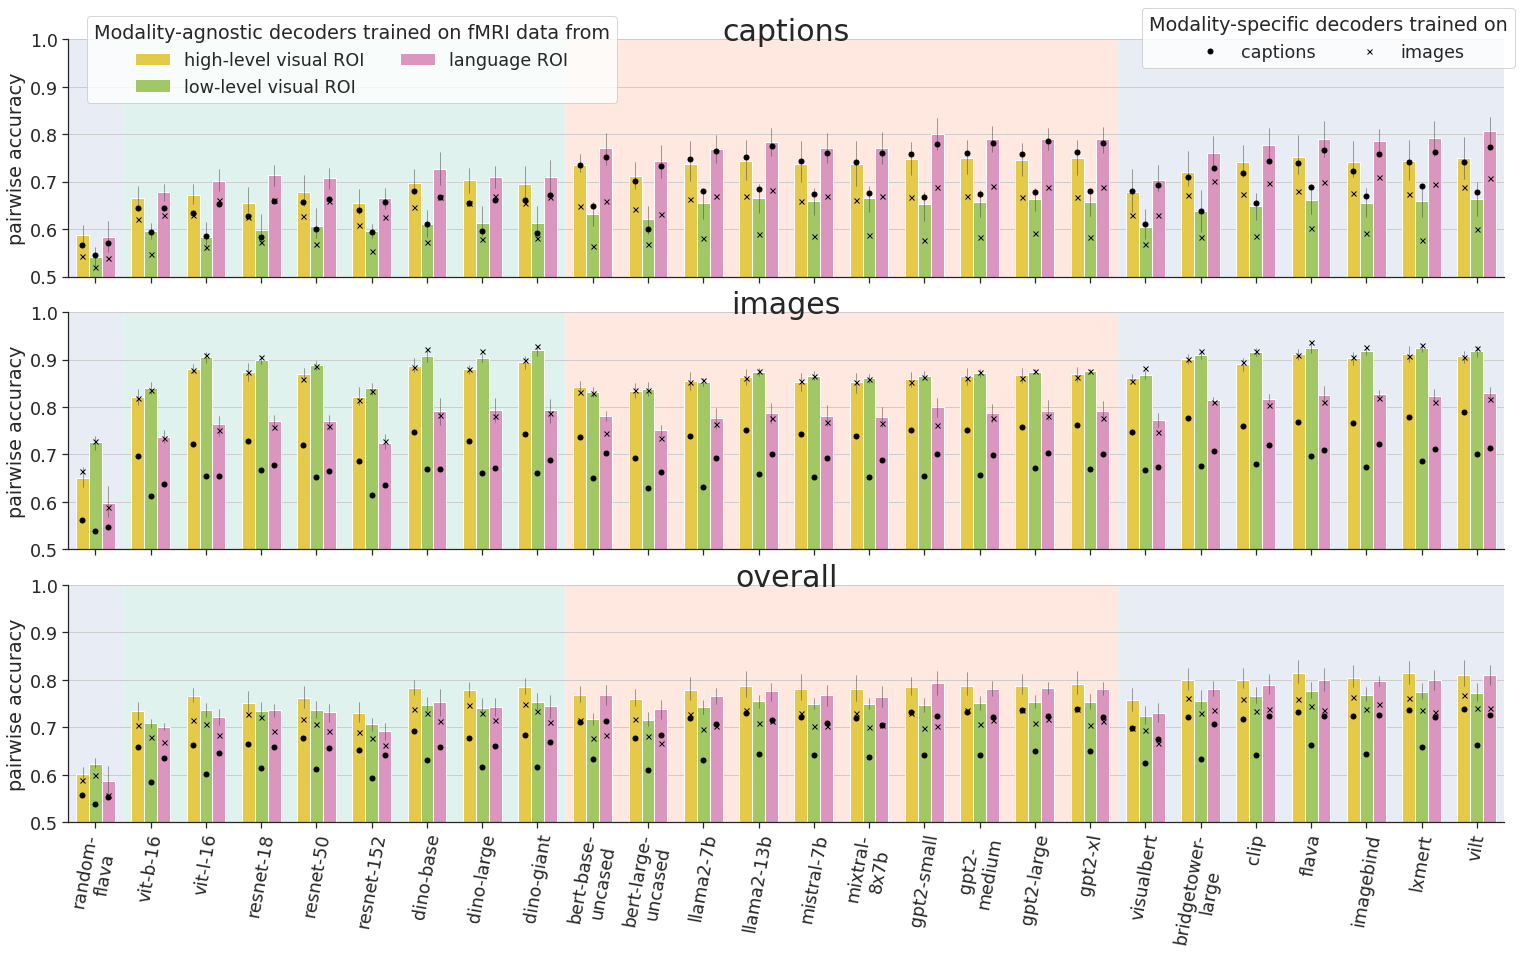

In [20]:
MASK_ORDER = ["high-level visual ROI", "low-level visual ROI", "language ROI"]
# MASK_ORDER = ["high-level visual ROI", "low-level visual ROI", "language ROI", "functional_Language", "functional_Visual1", "functional_Visual2", "functional_Default", "functional_Visual1_Visual2"]

# MASK_PALETTE = sns.color_palette('Set2')[:3+len(MASK_ORDER)][::-1] #TODO
MASK_PALETTE = sns.color_palette('Set2')[3:3+len(MASK_ORDER)][::-1]


# outdated mask:
all_data_avg = all_data_avg[all_data_avg["mask"] != "occipital"]

# MODEL_FEATS_INCLUDED = ["resnet-50_vision", "dino-giant_vision", "gpt2-large_lang", "llama2-13b_lang", "flava_vision+lang"]
# data_all_masks = all_data_avg[all_data_avg.model_feat.isin(MODEL_FEATS_INCLUDED)].copy()

MODEL_FEATS_EXCLUDED = ["bridgetower-large_multi", "random-flava_vision", "random-flava_lang"] + MODEL_FEAT_MULTIMODAL_SINGLE_MODALITY
data_all_masks = all_data_avg[~all_data_avg.model_feat.isin(MODEL_FEATS_EXCLUDED)].copy()

# MODEL_FEATS_INCLUDED = ["vilt_vision+lang"]
# data_all_masks = all_data_avg[all_data_avg.model_feat.isin(MODEL_FEATS_INCLUDED)].copy()


data_all_masks["mask"] = data_all_masks["mask"].replace({"anatomical_occipital_exclusive": "low-level visual ROI", "anatomical_lang": "language ROI", "anatomical_visual_high_level": "high-level visual ROI"})

data_all_masks = data_all_masks[data_all_masks["mask"].isin(MASK_ORDER)].copy()

model_feat_order = calc_model_feat_order(data_all_masks)

metrics_order = ["pairwise_acc_captions", "pairwise_acc_images", "pairwise_acc"]

dodge = 0.47
# dodge = 0.6
figure, lgd = create_result_graph(data_all_masks, model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_variable="mask", hue_order=MASK_ORDER, palette=MASK_PALETTE, ylim=(0.5, 1),
                                  legend_title="Modality-agnostic decoders trained on fMRI data from", dodge=dodge, legend_bbox=(0.06,0.99))

colors_bg = sns.color_palette('Set2')[:3]
for i in range(len(figure.axes)):
    figure.axes[i, 0].axvspan(-0.5, 0.5, facecolor=colors_bg[2], alpha=0.2, zorder=-100)
    figure.axes[i, 0].axvspan(0.5, 8.5, facecolor=colors_bg[0], alpha=0.2, zorder=-100)
    figure.axes[i, 0].axvspan(8.5, 18.5, facecolor=colors_bg[1], alpha=0.2, zorder=-100)
    figure.axes[i, 0].axvspan(18.5, 25.5, facecolor=colors_bg[2], alpha=0.2, zorder=-100)
plt.xlim((-0.5, 25.5))


# plt.subplots_adjust(top=0.98, bottom=0.05, hspace=0)
plt.savefig(os.path.join(RESULTS_DIR, f"roi_comparison_pairwise_acc_with_modality_agnostic.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)

## Per-subject results

In [21]:
FEAT_ORDER = ["vision", "lang", "vision+lang"]
FEAT_PALETTE = sns.color_palette('Set2')[:3]

def create_result_graph_all_subjs(data, model_feat_order, metrics=["pairwise_acc_captions", "pairwise_acc_images"], hue_variable="features", hue_order=FEAT_ORDER, ylim=None,
                        legend_title="Modality-agnostic decoders based on features from", palette=FEAT_PALETTE, dodge=False, noise_ceilings=None, plot_modality_specific=True,
                       row_variable="metric", col_variable=None):
    data_training_mode_full = data[data.training_mode == "modality-agnostic"]


    assert len(data_training_mode_full[(data_training_mode_full.model_feat == 'gpt2-large_lang') & (data_training_mode_full.metric == metrics[0]) & (data_training_mode_full[hue_variable] == data_training_mode_full[hue_variable].values[0])]) == 6

    catplot_g, data_plotted, lgd = plot_metric_catplot(data_training_mode_full, order=model_feat_order, metrics=metrics, x_variable="model_feat", legend_title=legend_title, aspect=2, legend_bbox=(0,1.05), rotation=89, cut_labels=False,
                                                  hue_variable=hue_variable, row_variable=row_variable, col_variable=col_variable, hue_order=hue_order, palette=palette, ylim=ylim, noise_ceilings=noise_ceilings)

    if plot_modality_specific:
        for i, subj in zip(range(6), SUBJECTS):
            data_subj = data[data.subject == subj]
            data_training_mode_captions = data_subj[data_subj.training_mode == "captions"]
            data_training_mode_images = data_subj[data_subj.training_mode == "images"]
            _ = plot_metric(data_training_mode_captions, kind="point", order=model_feat_order, metric=metrics[0], x_variable="model_feat", dodge=dodge,
                                          hue_variable=hue_variable, hue_order=hue_order, palette=[(0, 0, 0)], axis=catplot_g.axes[i, 0], marker="o", plot_legend=False, ylim=ylim)
            g, _ = plot_metric(data_training_mode_images, kind="point", order=model_feat_order, metric=metrics[0], x_variable="model_feat", dodge=dodge,
                                          hue_variable=hue_variable, hue_order=hue_order, palette=[(0, 0, 0)], axis=catplot_g.axes[i, 0], marker="x", plot_legend=False, ylim=ylim)
            
            _ = plot_metric(data_training_mode_captions, kind="point", order=model_feat_order, metric=metrics[1], x_variable="model_feat", dodge=dodge,
                                          hue_variable=hue_variable, hue_order=hue_order, palette=[(0, 0, 0)], axis=catplot_g.axes[i, 1], marker="o", plot_legend=False, ylim=ylim)
            _ = plot_metric(data_training_mode_images, kind="point", order=model_feat_order, metric=metrics[1], x_variable="model_feat", dodge=dodge,
                                          hue_variable=hue_variable, hue_order=hue_order, palette=[(0, 0, 0)], axis=catplot_g.axes[i, 1], marker="x", plot_legend=False, ylim=ylim)
        
        handles, labels = g.get_legend_handles_labels()
        new_labels = ["captions", "images"]
        new_handles = [handles[0], handles[-1]]
        catplot_g.fig.legend(handles=new_handles, labels=new_labels, ncol=2, title="Modality-specific decoders trained on", loc='upper right')

        for i in range(6):
            catplot_g.axes[i,0].set_title(f"subject {i+1} | captions", fontsize=25)
            catplot_g.axes[i,1].set_title(f"subject {i+1} | images", fontsize=25)

            catplot_g.axes[i,0].set_ylabel('pairwise accuracy')

    return catplot_g, lgd


<ipython-input-9-f46e84c1ecf3>:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels([get_short_label_text(label, cut_labels) for label in last_axis.get_xticklabels()], rotation=rotation)
<ipython-input-9-f46e84c1ecf3>:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels([get_short_label_text(label, cut_labels) for label in last_axis.get_xticklabels()], rotation=rotation)
<ipython-input-8-253b4d8a486d>:9: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  g = sns.pointplot(data_filtered, x=x_variable, order=order, y="value", hue=hue_variable, hue_order=hue_order, palette=palette,
<ipython-input-8-253b4d8a486d>:9: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, whic

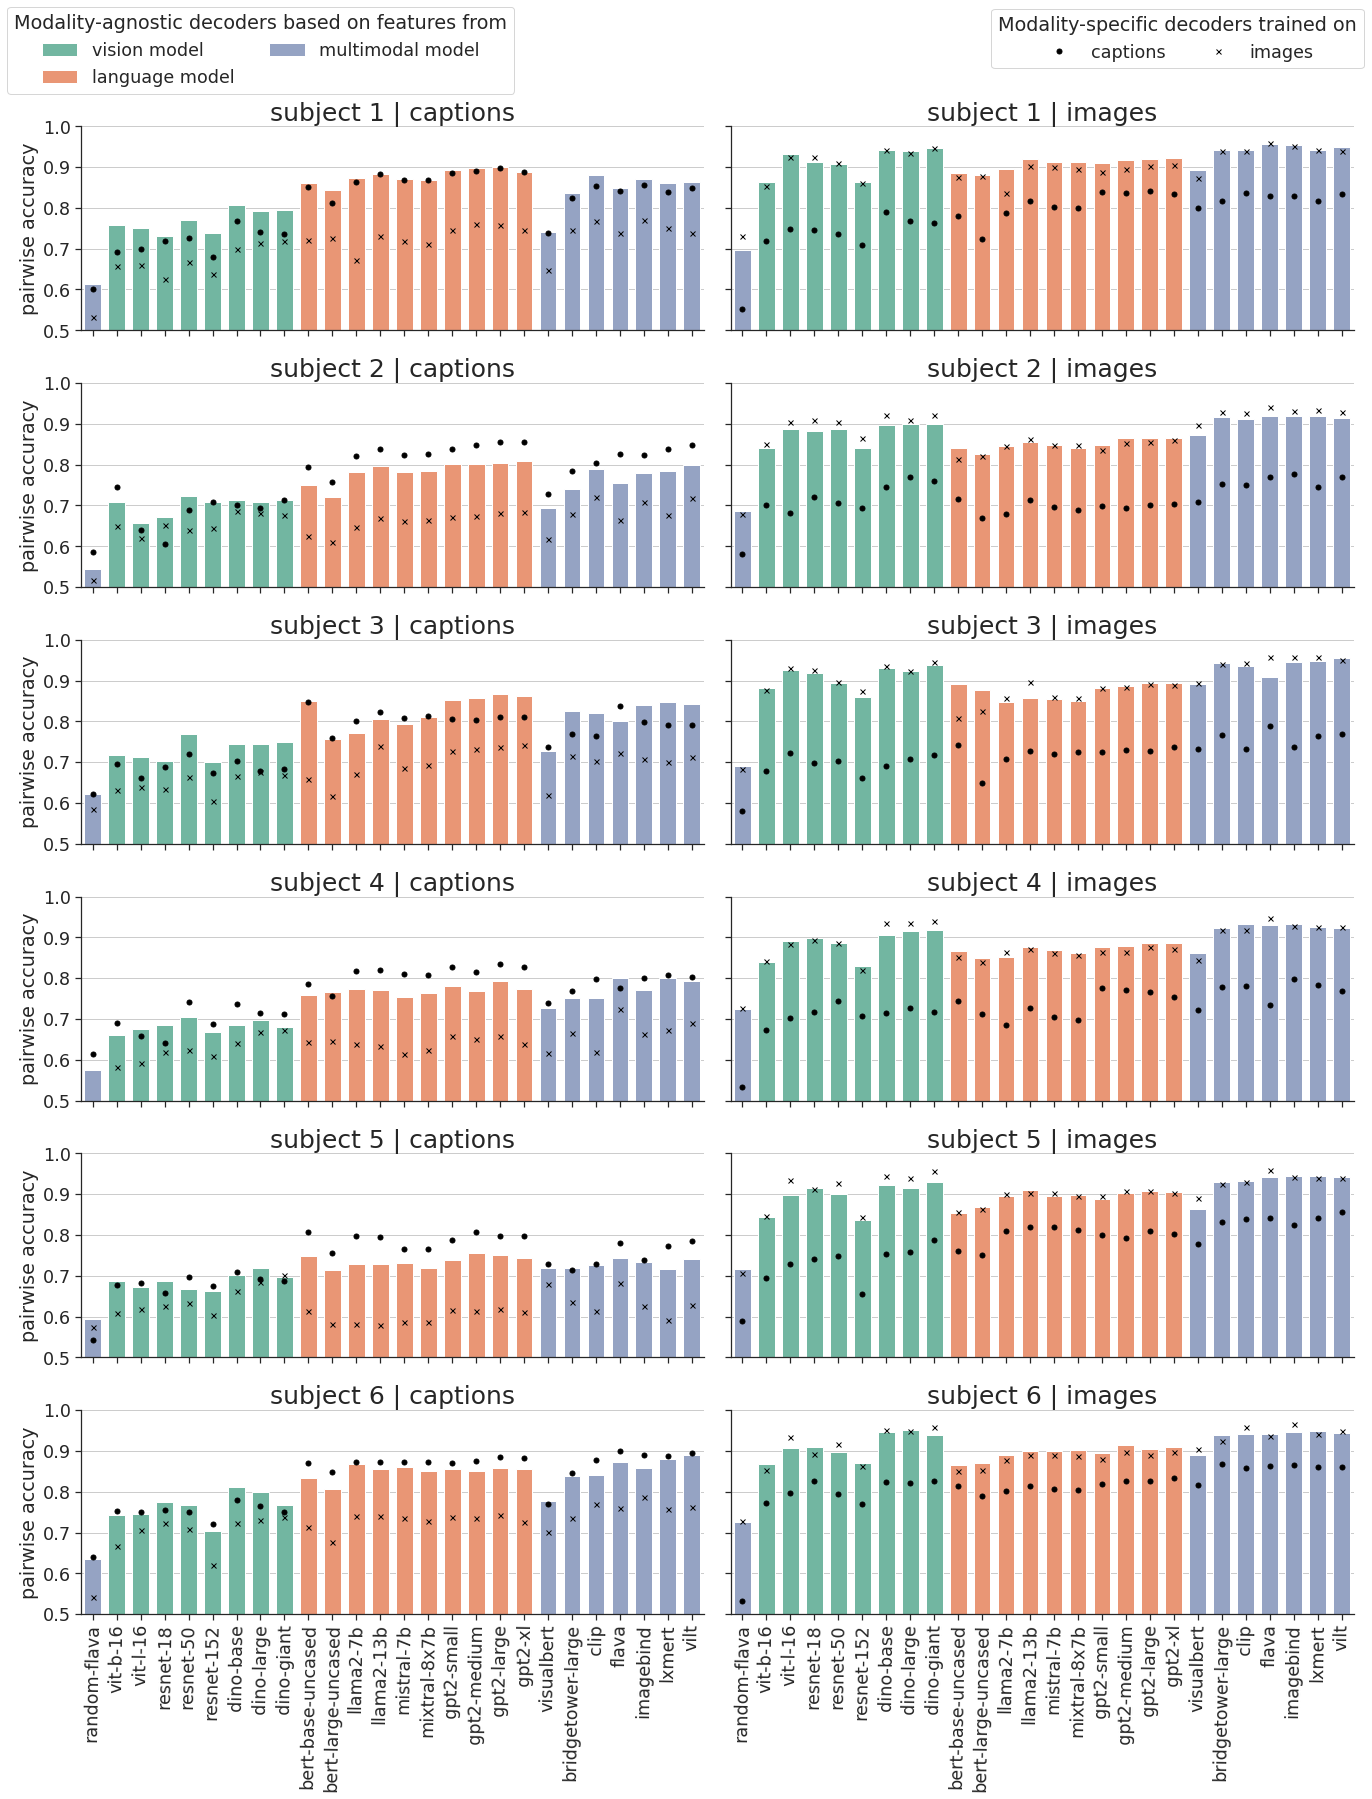

In [22]:
TRAIN_MODE_ORDER = ["images", "captions", "modality-agnostic"]
FEAT_ORDER = ["vision model", "language model", "multimodal model"]

MODEL_FEATS_EXCLUDED = ["bridgetower-large_multi", "random-flava_vision", "random-flava_lang"] + MODEL_FEAT_MULTIMODAL_SINGLE_MODALITY
data_to_plot = all_data[~all_data.model_feat.isin(MODEL_FEATS_EXCLUDED)].copy()

data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision model", "lang": "language model", "vision+lang": "multimodal model"})

data_to_plot = data_to_plot[data_to_plot["mask"] == "whole_brain"]
model_feat_order = calc_model_feat_order(data_to_plot)

figure, lgd = create_result_graph_all_subjs(data_to_plot, model_feat_order, metrics=["pairwise_acc_captions", "pairwise_acc_images"], hue_order=FEAT_ORDER, ylim=(0.5, 1), row_variable="subject", col_variable="metric")
plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_pairwise_acc_per_subject.png"), dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0)

## RSA noise ceiling

In [23]:
RSA_METRIC = "spearmanr"
RSA_MATRIX_METRIC = "spearmanr"
rsa_noise_ceilings_path = os.path.join(RSA_NOISE_CEILING_DIR, f"{RSA_METRIC}_{RSA_MATRIX_METRIC}.p")
rsa_noise_ceilings = pickle.load(open(rsa_noise_ceilings_path, 'rb'))
rsa_noise_ceiling_captions_mean = np.mean(list(rsa_noise_ceilings["rsa_captions"].values()))
rsa_noise_ceiling_images_mean = np.mean(list(rsa_noise_ceilings["rsa_images"].values()))

# rsa_noise_ceiling_std = np.std(list(rsa_noise_ceilings.values()))
print(rsa_noise_ceiling_captions_mean)
print(rsa_noise_ceiling_images_mean)

# print(rsa_noise_ceiling_std)
# g, _ = plot_metrics(data_to_plot, metrics=["rsa_spearmanr_spearmanr"], ylim=(0, 0.7), palette=palette, hue_order=model_feat_order, noise_ceiling=rsa_noise_ceiling_mean)
# g, _ = plot_metrics(data_to_plot, metrics=["rsa_spearmanr_spearmanr"], ylim=(0, 0.3), palette=palette, hue_order=model_feat_order)


0.016981539366333558
0.15442422589374546


In [24]:
all_data_no_mask = all_data[all_data["mask"] == "whole_brain"]
all_data_no_mask[(all_data_no_mask.subject == 'sub-03')].alpha

2146      10000.0
2147      10000.0
2148      10000.0
2149      10000.0
2150      10000.0
           ...   
16346    100000.0
16347    100000.0
16348    100000.0
16349    100000.0
16350    100000.0
Name: alpha, Length: 786, dtype: float64